## Use phot-griz environment (updated photutils)

In [1]:
# General imports
import os
import numpy as np
import matplotlib.pyplot as plt

# Segmentation
from astropy.io import fits
from photutils.segmentation import SourceFinder, make_2dgaussian_kernel, SourceCatalog
from photutils.background import Background2D, MedianBackground
from astropy.convolution import convolve

# grizli
from grizli.model import GrismFLT
import grizli

os.chdir("/Users/keith/astr/research_astr/summer-roman-project/FOV0_sims/fits")


In [2]:
# Process direct image and produce segmentation map

# Open image
direct_file = "rotated_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits"
seg_file = "seg.fits"
direct_fits = fits.open(direct_file)
data, header = (direct_fits[1].data, direct_fits[1].header)


# Subtract background
bkg_estimator = MedianBackground()
bkg = Background2D(data, (511,511), filter_size=(3,3), bkg_estimator=bkg_estimator)
data -= bkg.background

# Convolve image
kernel = make_2dgaussian_kernel(3.0, 5)
convolved_data = convolve(data, kernel)

# Instantiate the SourceFinder and set threshold
finder = SourceFinder(npixels=7, nlevels=32, contrast=0.001)
threshold = 2 * bkg.background_rms

seg_map = finder(convolved_data, threshold)

# Save seg_map as fits
fits.writeto(seg_file, seg_map, header=header,overwrite=True)

Deblending:   0%|          | 0/6281 [00:00<?, ?it/s]

In [3]:
# Create Catalog
cat = SourceCatalog(data, seg_map, convolved_data=convolved_data)
cat.add_extra_property('id', cat.label, overwrite=True)
cat.add_extra_property('x_flt', cat.xcentroid, overwrite=True)
cat.add_extra_property('y_flt', cat.ycentroid, overwrite=True)
mag = -2.5 * np.log10(cat.segment_flux)
cat.add_extra_property('mag', mag, overwrite=True)

columns = ['id', 'x_flt', 'y_flt', 'mag', 'area', 'semimajor_sigma', 'semiminor_sigma',
           'orientation', 'eccentricity', 'min_value', 'max_value']
tbl = cat.to_table(columns)

In [4]:
# Mask a box on the sky
mask = (abs(tbl["x_flt"] - 1000) < 100) & (abs(tbl["y_flt"] - 1050) < 100)
print(np.sum(mask))
# print(np.min(tbl['mag'][mask]), np.max(tbl['mag'][mask]))
tbl[id==2]['mag']

17


-2.5230022221505544

In [5]:
# Instantiate the GrismFLT object
sim_fov0 = GrismFLT(direct_file=direct_file, seg_file=seg_file, pad=(0,0), force_grism="None")



Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None)
rotated_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 64 pixels
rotated_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation seg.fits[0]
The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...


In [6]:
dis_test = grizli.model.GrismDisperser(id=2).cutout_from_full_image(data)

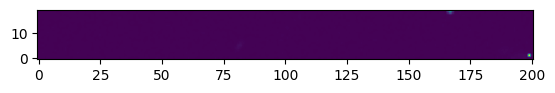

In [12]:
plt.imshow(dis_test, origin='lower')

In [7]:
# Set the size sufficiently large that the calculated thumbnail for each object has enough from for the dispersion.
sim_fov0.compute_full_model(ids=[2], mags=[tbl[id==2]['mag']], min_size=0, compute_size=False)

In [8]:
np.max(sim_fov0.model)

0.0

Text(0.5, 1.0, 'Masked Simulation cutout')

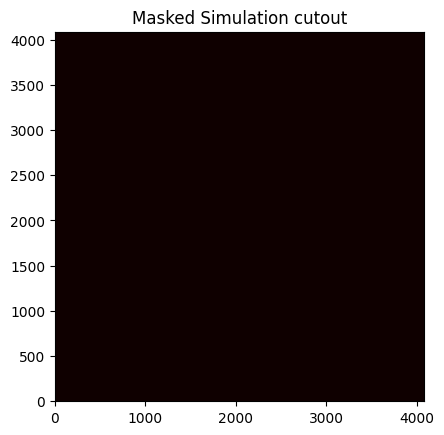

In [9]:
fig, ax = plt.subplots()
ax.imshow(sim_fov0.model, interpolation='Nearest', 
           origin='lower', vmin=-0.01, vmax=1, cmap='hot')
# ax.set_xlim(500,1500)
# ax.set_ylim(500,1500)
ax.set_title("Masked Simulation cutout")